In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
mobley_id = find_players_by_full_name("Ja Morant")[0]['id']

In [7]:
shot_data = ShotChartDetail(team_id=0, player_id=mobley_id, season_nullable='2021-22', context_measure_simple='FGA').get_data_frames()[0]

In [8]:
shot_data.iloc[0]

GRID_TYPE               Shot Chart Detail
GAME_ID                        0022100007
GAME_EVENT_ID                           8
PLAYER_ID                         1629630
PLAYER_NAME                     Ja Morant
TEAM_ID                        1610612763
TEAM_NAME               Memphis Grizzlies
PERIOD                                  1
MINUTES_REMAINING                      11
SECONDS_REMAINING                      23
EVENT_TYPE                      Made Shot
ACTION_TYPE            Driving Layup Shot
SHOT_TYPE                  2PT Field Goal
SHOT_ZONE_BASIC           Restricted Area
SHOT_ZONE_AREA                  Center(C)
SHOT_ZONE_RANGE           Less Than 8 ft.
SHOT_DISTANCE                           2
LOC_X                                   6
LOC_Y                                  21
SHOT_ATTEMPTED_FLAG                     1
SHOT_MADE_FLAG                          1
GAME_DATE                        20211020
HTM                                   MEM
VTM                               

In [9]:
game_log_mobley = shot_data.groupby(['GAME_ID', 'SHOT_ZONE_BASIC']).agg(
    {
        'SHOT_ATTEMPTED_FLAG': 'sum',
        'SHOT_MADE_FLAG': 'sum'
    }
).unstack()

In [10]:
game_log_mobley = game_log_mobley.fillna(0.0)

In [11]:
game_ids = shot_data.GAME_ID.unique().tolist()

In [12]:
areas = [
    'In The Paint (Non-RA)',
    'Mid-Range',
    'Restricted Area',
    'Left Corner 3',
    'Above the Break 3',
    'Right Corner 3'
]

In [13]:
final_areas = [item.replace(" ", "_").replace("-", "_").upper() for item in [
    'In The Paint',
    'Mid-Range',
    'Restricted Area',
    'Left Corner 3',
    'Above the Break 3',
    'Right Corner 3'
]]

In [24]:
shot_data

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0022100007,7,1630596,Evan Mobley,1610612739,Cleveland Cavaliers,1,11,46,...,Left Side(L),8-16 ft.,12,-67,105,1,1,20211020,MEM,CLE
1,Shot Chart Detail,0022100007,169,1630596,Evan Mobley,1610612739,Cleveland Cavaliers,2,11,10,...,Left Side(L),8-16 ft.,10,-92,60,1,0,20211020,MEM,CLE
2,Shot Chart Detail,0022100007,174,1630596,Evan Mobley,1610612739,Cleveland Cavaliers,2,10,45,...,Center(C),Less Than 8 ft.,1,4,10,1,1,20211020,MEM,CLE
3,Shot Chart Detail,0022100007,188,1630596,Evan Mobley,1610612739,Cleveland Cavaliers,2,9,49,...,Center(C),16-24 ft.,17,25,174,1,0,20211020,MEM,CLE
4,Shot Chart Detail,0022100007,210,1630596,Evan Mobley,1610612739,Cleveland Cavaliers,2,7,54,...,Left Side(L),8-16 ft.,15,-94,123,1,1,20211020,MEM,CLE
5,Shot Chart Detail,0022100007,225,1630596,Evan Mobley,1610612739,Cleveland Cavaliers,2,6,44,...,Left Side(L),16-24 ft.,19,-190,47,1,0,20211020,MEM,CLE
6,Shot Chart Detail,0022100007,408,1630596,Evan Mobley,1610612739,Cleveland Cavaliers,3,6,32,...,Center(C),Less Than 8 ft.,6,-16,63,1,0,20211020,MEM,CLE
7,Shot Chart Detail,0022100007,458,1630596,Evan Mobley,1610612739,Cleveland Cavaliers,3,3,30,...,Right Side(R),8-16 ft.,8,88,17,1,0,20211020,MEM,CLE
8,Shot Chart Detail,0022100007,463,1630596,Evan Mobley,1610612739,Cleveland Cavaliers,3,2,56,...,Left Side(L),24+ ft.,22,-223,30,1,1,20211020,MEM,CLE
9,Shot Chart Detail,0022100007,466,1630596,Evan Mobley,1610612739,Cleveland Cavaliers,3,2,29,...,Center(C),24+ ft.,24,56,243,1,0,20211020,MEM,CLE


In [14]:
data = {}
for game in game_ids:
    cur_game = shot_data.loc[shot_data.GAME_ID == game]
    if 'GAME_ID' not in data:
        data['GAME_ID'] = []
    data['GAME_ID'].append(game)
    for column in areas:
        stripped_column = column.strip().replace(" ", "_").replace("-", "_").upper()
        if "In The" in column:
            stripped_column = column.split("(")[0].strip().replace(" ", "_").upper()
        if f"{stripped_column}_MADE" not in data:
            data[f"{stripped_column}_MADE"] = []
        made = len(cur_game.loc[(cur_game.SHOT_ZONE_BASIC == column) & (cur_game.SHOT_MADE_FLAG == 1)])
        data[f"{stripped_column}_MADE"].append(made)
        if f"{stripped_column}_ATTEMPTED" not in data:
            data[f"{stripped_column}_ATTEMPTED"] = []
        attempts = len(cur_game.loc[(cur_game.SHOT_ZONE_BASIC == column) & (cur_game.SHOT_ATTEMPTED_FLAG == 1)])
        data[f"{stripped_column}_ATTEMPTED"].append(attempts)
        if f"{stripped_column}_PCT" not in data:
            data[f"{stripped_column}_PCT"] = []
        if made > 0:
            data[f"{stripped_column}_PCT"].append(made / attempts * 100)
        else:
            data[f"{stripped_column}_PCT"].append(0)

In [15]:
df = pd.DataFrame(data)

In [16]:
df = df.reset_index()

In [17]:
df

,index,GAME_ID,IN_THE_PAINT_MADE,IN_THE_PAINT_ATTEMPTED,IN_THE_PAINT_PCT,MID_RANGE_MADE,MID_RANGE_ATTEMPTED,MID_RANGE_PCT,RESTRICTED_AREA_MADE,RESTRICTED_AREA_ATTEMPTED,RESTRICTED_AREA_PCT,LEFT_CORNER_3_MADE,LEFT_CORNER_3_ATTEMPTED,LEFT_CORNER_3_PCT,ABOVE_THE_BREAK_3_MADE,ABOVE_THE_BREAK_3_ATTEMPTED,ABOVE_THE_BREAK_3_PCT,RIGHT_CORNER_3_MADE,RIGHT_CORNER_3_ATTEMPTED,RIGHT_CORNER_3_PCT
0,0,0022100007,3,6,50.000000,1,2,50.000000,12,17,70.588235,0,0,0.0,1,4,25.000000,0,0,0.0
1,1,0022100034,4,8,50.000000,0,0,0.000000,4,4,100.000000,0,0,0.0,2,7,28.571429,0,0,0.0
2,2,0022100040,0,2,0.000000,0,0,0.000000,8,12,66.666667,0,0,0.0,4,6,66.666667,1,1,100.0
3,3,0022100063,1,2,50.000000,0,1,0.000000,1,3,33.333333,0,0,0.0,2,4,50.000000,1,2,50.0
4,4,0022100070,4,7,57.142857,2,3,66.666667,3,4,75.000000,0,0,0.0,2,7,28.571429,0,1,0.0
5,5,0022100084,1,1,100.000000,0,2,0.000000,5,11,45.454545,1,1,100.0,0,3,0.000000,0,0,0.0
6,6,0022100100,6,9,66.666667,0,3,0.000000,5,7,71.428571,0,0,0.0,1,3,33.333333,0,0,0.0
7,7,0022100114,2,5,40.000000,0,1,0.000000,6,8,75.000000,0,0,0.0,0,2,0.000000,0,0,0.0
8,8,0022100126,1,9,11.111111,0,3,0.000000,3,3,100.000000,0,0,0.0,0,2,0.000000,0,0,0.0
9,9,0022100149,3,11,27.272727,1,2,50.000000,3,5,60.000000,0,0,0.0,3,6,50.000000,0,0,0.0


In [66]:
df.loc[(df.IN_THE_PAINT_PCT > 50) & (df.IN_THE_PAINT_ATTEMPTED > 2) ]

,index,GAME_ID,IN_THE_PAINT_MADE,IN_THE_PAINT_ATTEMPTED,IN_THE_PAINT_PCT,MID_RANGE_MADE,MID_RANGE_ATTEMPTED,MID_RANGE_PCT,RESTRICTED_AREA_MADE,RESTRICTED_AREA_ATTEMPTED,RESTRICTED_AREA_PCT,LEFT_CORNER_3_MADE,LEFT_CORNER_3_ATTEMPTED,LEFT_CORNER_3_PCT,ABOVE_THE_BREAK_3_MADE,ABOVE_THE_BREAK_3_ATTEMPTED,ABOVE_THE_BREAK_3_PCT,RIGHT_CORNER_3_MADE,RIGHT_CORNER_3_ATTEMPTED,RIGHT_CORNER_3_PCT
0,0,0022100007,2,3,66.666667,1,5,20.000000,3,3,100.000000,1,1,100.0,0,1,0.0,0,0,0.0
10,10,0022100140,3,3,100.000000,0,1,0.000000,6,7,85.714286,0,0,0.0,1,2,50.0,1,2,50.0
13,13,0022100190,3,4,75.000000,2,4,50.000000,2,3,66.666667,0,0,0.0,1,2,50.0,0,0,0.0
16,16,0022100310,2,3,66.666667,0,1,0.000000,3,4,75.000000,0,0,0.0,0,2,0.0,0,0,0.0
21,21,0022100367,3,5,60.000000,1,1,100.000000,4,5,80.000000,0,0,0.0,0,0,0.0,0,0,0.0
25,25,0022100513,6,7,85.714286,0,1,0.000000,2,2,100.000000,0,0,0.0,1,2,50.0,0,0,0.0
26,26,0022100527,5,9,55.555556,2,4,50.000000,3,5,60.000000,0,0,0.0,0,2,0.0,0,0,0.0
28,28,0022100547,3,4,75.000000,4,6,66.666667,4,4,100.000000,0,0,0.0,0,2,0.0,0,0,0.0
32,32,0022100611,3,5,60.000000,3,4,75.000000,2,4,50.000000,0,0,0.0,0,1,0.0,0,0,0.0
33,33,0022100624,4,4,100.000000,1,1,100.000000,2,4,50.000000,0,0,0.0,0,0,0.0,0,0,0.0


In [64]:
df.iloc[-5:].MID_RANGE_MADE.sum() / df.iloc[-5:].MID_RANGE_ATTEMPTED.sum()

0.5

In [71]:
[made / attempted for made, attempted in zip(df.IN_THE_PAINT_MADE.cumsum(), df.IN_THE_PAINT_ATTEMPTED.cumsum())]

[0.6666666666666666,
 0.5,
 0.42857142857142855,
 0.3333333333333333,
 0.25,
 0.26666666666666666,
 0.2222222222222222,
 0.20833333333333334,
 0.19230769230769232,
 0.22580645161290322,
 0.29411764705882354,
 0.3076923076923077,
 0.3170731707317073,
 0.35555555555555557,
 0.3333333333333333,
 0.33962264150943394,
 0.35714285714285715,
 0.3448275862068966,
 0.328125,
 0.3235294117647059,
 0.3142857142857143,
 0.3333333333333333,
 0.3333333333333333,
 0.32926829268292684,
 0.3176470588235294,
 0.358695652173913,
 0.37623762376237624,
 0.38095238095238093,
 0.3944954128440367,
 0.39473684210526316,
 0.38333333333333336,
 0.3870967741935484,
 0.3953488372093023,
 0.41353383458646614,
 0.4057971014492754,
 0.4195804195804196,
 0.410958904109589]

In [70]:
df.IN_THE_PAINT_ATTEMPTED.cumsum()

0       3
1       6
2       7
3       9
4      12
5      15
6      18
7      24
8      26
9      31
10     34
11     39
12     41
13     45
14     48
15     53
16     56
17     58
18     64
19     68
20     70
21     75
22     75
23     82
24     85
25     92
26    101
27    105
28    109
29    114
30    120
31    124
32    129
33    133
34    138
35    143
36    146
Name: IN_THE_PAINT_ATTEMPTED, dtype: int64

In [78]:
plt.style.use('fivethirtyeight')

Text(0.5, 0, 'Number of game in season')

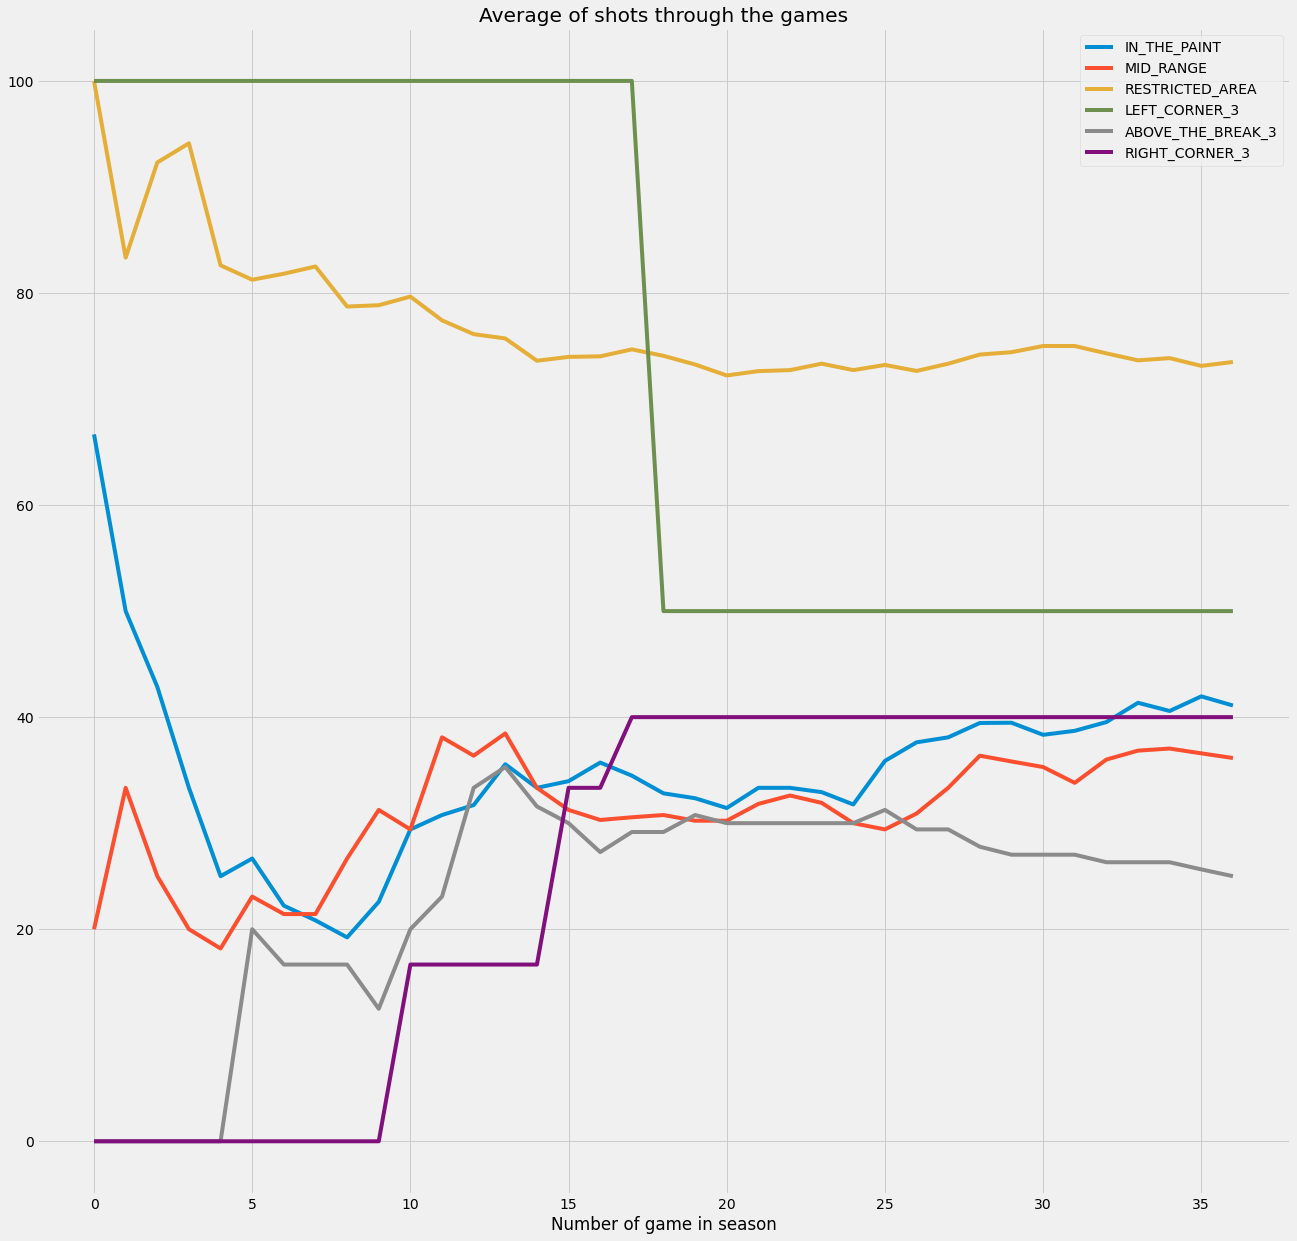

In [81]:
fig, ax = plt.subplots(figsize=(20, 20))

for area in final_areas:
    ax.plot([made / attempted * 100 if attempted > 0 else 0.0 for made, attempted in zip(df[f"{area}_MADE"].cumsum(), df[f"{area}_ATTEMPTED"].cumsum())], label=area)

ax.legend()
ax.set_title("Average of shots through the games")
ax.set_xlabel("Number of game in season")
ax.set_ylabel("Percentage")

In [83]:
df.rolling(window=5).mean()

,index,GAME_ID,IN_THE_PAINT_MADE,IN_THE_PAINT_ATTEMPTED,IN_THE_PAINT_PCT,MID_RANGE_MADE,MID_RANGE_ATTEMPTED,MID_RANGE_PCT,RESTRICTED_AREA_MADE,RESTRICTED_AREA_ATTEMPTED,RESTRICTED_AREA_PCT,LEFT_CORNER_3_MADE,LEFT_CORNER_3_ATTEMPTED,LEFT_CORNER_3_PCT,ABOVE_THE_BREAK_3_MADE,ABOVE_THE_BREAK_3_ATTEMPTED,ABOVE_THE_BREAK_3_PCT,RIGHT_CORNER_3_MADE,RIGHT_CORNER_3_ATTEMPTED,RIGHT_CORNER_3_PCT
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,22100032.6,0.6,2.4,20.000000,0.4,2.2,24.000000,3.8,4.6,83.333333,0.2,0.2,20.0,0.0,0.6,0.000000,0.0,0.0,0.000000
5,3.0,22100046.6,0.4,2.4,13.333333,0.4,1.6,30.000000,4.6,5.8,78.888889,0.0,0.0,0.0,0.2,0.8,10.000000,0.0,0.0,0.000000
6,4.0,22100060.8,0.2,2.4,6.666667,0.2,1.6,10.000000,4.4,5.4,85.555556,0.0,0.0,0.0,0.2,1.0,10.000000,0.0,0.0,0.000000
7,5.0,22100074.2,0.4,3.4,10.000000,0.2,1.2,10.000000,4.2,5.4,82.698413,0.0,0.0,0.0,0.2,0.6,10.000000,0.0,0.4,0.000000
8,6.0,22100086.2,0.4,3.4,10.000000,0.4,1.0,30.000000,4.2,6.0,74.126984,0.0,0.0,0.0,0.2,0.6,10.000000,0.0,0.6,0.000000
9,7.0,22100098.8,0.8,3.8,18.000000,0.6,1.0,50.000000,4.4,5.8,80.126984,0.0,0.0,0.0,0.2,1.0,10.000000,0.0,0.8,0.000000


In [116]:
all_shots = ShotChartDetail(team_id=0, player_id=0, season_nullable='2021-22', context_measure_simple='FGA').get_data_frames()[0]

In [117]:
all_attempts = all_shots.groupby(['PLAYER_NAME', 'GAME_ID', 'SHOT_ZONE_BASIC']).agg(
    {
        'SHOT_MADE_FLAG': 'sum',
        'SHOT_ATTEMPTED_FLAG': 'sum'
    }
).unstack().fillna(0.0)

In [118]:
all_attempts.columns

MultiIndex([(     'SHOT_MADE_FLAG',     'Above the Break 3'),
            (     'SHOT_MADE_FLAG',             'Backcourt'),
            (     'SHOT_MADE_FLAG', 'In The Paint (Non-RA)'),
            (     'SHOT_MADE_FLAG',         'Left Corner 3'),
            (     'SHOT_MADE_FLAG',             'Mid-Range'),
            (     'SHOT_MADE_FLAG',       'Restricted Area'),
            (     'SHOT_MADE_FLAG',        'Right Corner 3'),
            ('SHOT_ATTEMPTED_FLAG',     'Above the Break 3'),
            ('SHOT_ATTEMPTED_FLAG',             'Backcourt'),
            ('SHOT_ATTEMPTED_FLAG', 'In The Paint (Non-RA)'),
            ('SHOT_ATTEMPTED_FLAG',         'Left Corner 3'),
            ('SHOT_ATTEMPTED_FLAG',             'Mid-Range'),
            ('SHOT_ATTEMPTED_FLAG',       'Restricted Area'),
            ('SHOT_ATTEMPTED_FLAG',        'Right Corner 3')],
           names=[None, 'SHOT_ZONE_BASIC'])

In [119]:
rolling_five = all_attempts.rolling(
    window=5,
).mean()

In [120]:
rolling_five

SHOT_MADE_FLAG                                  \
SHOT_ZONE_BASIC            Above the Break 3 Backcourt In The Paint (Non-RA)   
PLAYER_NAME     GAME_ID                                                        
Aaron Gordon    0022100012               NaN       NaN                   NaN   
                0022100024               NaN       NaN                   NaN   
                0022100048               NaN       NaN                   NaN   
                0022100054               NaN       NaN                   NaN   
                0022100075               0.2       0.0                   0.6   
...                                      ...       ...                   ...   
Ziaire Williams 0022100614               0.8       0.0                   0.2   
                0022100628               0.6       0.0                   0.2   
                0022100639               0.2       0.0                   0.0   
                0022100658               0.2       0.0                   0.0   
Zylan Cheatham  0022100624               0.0       0.0                   0.0   

                                                                    \
SHOT_ZONE_BASIC            Left Corner 3 Mid-Range Restricted Area   
PLAYER_NAME     GAME_ID                                              
Aaron Gordon    0022100012           NaN       NaN             NaN   
                0022100024           NaN       NaN             NaN   
                0022100048           NaN       NaN             NaN   
                0022100054           NaN       NaN             NaN   
                0022100075           0.2       0.6             3.8   
...                                  ...       ...             ...   
Ziaire Williams 0022100614           0.2       1.0             1.4   
                0022100628           0.2       0.8             1.6   
                0022100639           0.2       0.6             1.8   
                0022100658           0.2       0.4             1.6   
Zylan Cheatham  0022100624           0.2       0.0             1.4   

                                          SHOT_ATTEMPTED_FLAG            \
SHOT_ZONE_BASIC            Right Corner 3   Above the Break 3 Backcourt   
PLAYER_NAME     GAME_ID                                                   
Aaron Gordon    0022100012            NaN                 NaN       NaN   
                0022100024            NaN                 NaN       NaN   
                0022100048            NaN                 NaN       NaN   
                0022100054            NaN                 NaN       NaN   
                0022100075            0.2                 1.4       0.2   
...                                   ...                 ...       ...   
Ziaire Williams 0022100614            0.8                 2.4       0.0   
                0022100628            0.6                 2.2       0.0   
                0022100639            0.8                 1.8       0.0   
                0022100658            0.6                 2.2       0.0   
Zylan Cheatham  0022100624            0.6                 1.8       0.0   

                                                                          \
SHOT_ZONE_BASIC            In The Paint (Non-RA) Left Corner 3 Mid-Range   
PLAYER_NAME     GAME_ID                                                    
Aaron Gordon    0022100012                   NaN           NaN       NaN   
                0022100024                   NaN           NaN       NaN   
                0022100048                   NaN           NaN       NaN   
                0022100054                   NaN           NaN       NaN   
                0022100075                   1.2           0.6       1.2   
...                                          ...           ...       ...   
Ziaire Williams 0022100614                   1.0           0.8       1.4   
                0022100628                   1.0           1.0       1.0   
                0022100639               

In [121]:
zones = all_shots.SHOT_ZONE_BASIC.unique().tolist()

In [122]:
for zone in zones:
    rolling_five.loc[:, ('SHOT_PCT', zone)] = rolling_five[('SHOT_MADE_FLAG', zone)] / rolling_five[('SHOT_ATTEMPTED_FLAG', zone)]

In [123]:
rolling_five

SHOT_MADE_FLAG                                  \
SHOT_ZONE_BASIC            Above the Break 3 Backcourt In The Paint (Non-RA)   
PLAYER_NAME     GAME_ID                                                        
Aaron Gordon    0022100012               NaN       NaN                   NaN   
                0022100024               NaN       NaN                   NaN   
                0022100048               NaN       NaN                   NaN   
                0022100054               NaN       NaN                   NaN   
                0022100075               0.2       0.0                   0.6   
...                                      ...       ...                   ...   
Ziaire Williams 0022100614               0.8       0.0                   0.2   
                0022100628               0.6       0.0                   0.2   
                0022100639               0.2       0.0                   0.0   
                0022100658               0.2       0.0                   0.0   
Zylan Cheatham  0022100624               0.0       0.0                   0.0   

                                                                    \
SHOT_ZONE_BASIC            Left Corner 3 Mid-Range Restricted Area   
PLAYER_NAME     GAME_ID                                              
Aaron Gordon    0022100012           NaN       NaN             NaN   
                0022100024           NaN       NaN             NaN   
                0022100048           NaN       NaN             NaN   
                0022100054           NaN       NaN             NaN   
                0022100075           0.2       0.6             3.8   
...                                  ...       ...             ...   
Ziaire Williams 0022100614           0.2       1.0             1.4   
                0022100628           0.2       0.8             1.6   
                0022100639           0.2       0.6             1.8   
                0022100658           0.2       0.4             1.6   
Zylan Cheatham  0022100624           0.2       0.0             1.4   

                                          SHOT_ATTEMPTED_FLAG            \
SHOT_ZONE_BASIC            Right Corner 3   Above the Break 3 Backcourt   
PLAYER_NAME     GAME_ID                                                   
Aaron Gordon    0022100012            NaN                 NaN       NaN   
                0022100024            NaN                 NaN       NaN   
                0022100048            NaN                 NaN       NaN   
                0022100054            NaN                 NaN       NaN   
                0022100075            0.2                 1.4       0.2   
...                                   ...                 ...       ...   
Ziaire Williams 0022100614            0.8                 2.4       0.0   
                0022100628            0.6                 2.2       0.0   
                0022100639            0.8                 1.8       0.0   
                0022100658            0.6                 2.2       0.0   
Zylan Cheatham  0022100624            0.6                 1.8       0.0   

                                                  ...            \
SHOT_ZONE_BASIC            In The Paint (Non-RA)  ... Mid-Range   
PLAYER_NAME     GAME_ID                           ...             
Aaron Gordon    0022100012                   NaN  ...       NaN   
                0022100024                   NaN  ...       NaN   
                0022100048                   NaN  ...       NaN   
                0022100054                   NaN  ...       NaN   
                0022100075                   1.2  ...       1.2   
...                                          ...  ...       ...   
Ziaire Williams 0022100614                   1.0  ...       1.4   
                0022100628                   1.0  ...       1.0   
                0022100639                   0.8  ...       0.8   
                0022100658                   0.4  ...       0.8   
Zylan 